#Time Series prediction with LSTM

In [Writing like Cervantes](https://medium.com/@gjlr2000/writing-like-cervantes-61a63c964d82) I showed how LSTM-NN (Long Short Term Memory Neural Networks) show what a fellow blogger says is an "[unreasonable effectiveness(http://karpathy.github.io/2015/05/21/rnn-effectiveness/)". If you see the example I developed, you will see how the neural network 'learned' to write in Spanish (letter by letter) in a little under 2 hours after reading the whole 'Don Quijote'.

Not surprisingly, LSTM NN have been proposed to predict Time Series. 

**Spoiler alert:** Most of them do not work in Finance (so far I have only seen one that claims to work: [Universal Features of Price Formation in Financial Markets: Perspectives From Deep Learning - Sirignano and Cont](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3141294))). That could be because:

1.   practitioners who have implemented a working version of a neural network would use the whole extent of the law to keep it secret ( [Goldman suing ex-programmer](https://www.vanityfair.com/news/2013/09/michael-lewis-goldman-sachs-programmer)) and avoid the 'alpha destruction effect' that happens when a strategy is published [Does Academic Research Destroy Stock Return Predictability?](https://www2.bc.edu/jeffrey-pontiff/Documents/Predictability%20JF%20with%20copy%20edits%20Final.pdf)

2.  The timeseries cannot be predicted, because as as Sirignano and Cont write, "*the data used for estimation is often limited to a recent time window, ... financial data can be **‘non-stationary’** and **prone to regime changes** which may render older data less relevant for prediction.*" 

3. The timeseries can be predicted, but the practicioner/researcher does not have access to the full dataset/ computer power.

Below (after some discussion of points 2 and 3) I will show in full detail an example of time series prediction of the 5 year US rate. 


In [0]:
# -*- coding: utf-8 -*-

# In this section I add the initial libraries required for this tutorial
# 'requests': allow HTTP-post API calls
import requests
# 'json':     to format as json calls to API
import json 
# 'pandas':   to plot the timeseries
import pandas as pd
# 'datetime': to convert different date formats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

More about non-stationarity and regime changes -- you can read the formal definition in Wikipedia [non-stationary](https://en.wikipedia.org/wiki/Stationary_process)], but le me give you a real life example.

In September 6 of 2011 the [Swiss National Bank](https://en.wikipedia.org/wiki/Swiss_franc#2011%E2%80%932014:_Big_movements_and_capping):


> *set a minimum exchange rate of 1.20 francs to the euro (capping franc's appreciation) saying "the value of the franc is a threat to the economy",[18] and that it was "prepared to buy foreign currency in unlimited quantities"*

a policy that was abandoned on 15 January 2015.




The period when the Swiss Franc was capped versus the Euro correspond to the shaded region in the plot below. The big moves before and after correspond to **regimes changes**. The argument against neural networks being unable to identify them usually assumes that there is no additional variable that can be used to identify them, hence it can be weakened if we are able to **add** input variables which identifies the regimes (in this case, central bank intervention).

However, it is difficult to think ahead of the variables needed for prediction (it is always easier in hindsight), and if there are multiple regimes the data will be subdivided over and over, reducing the possibility of successful training (mental exercise: think what woulk happen if we take the 'Don Quixote' example mentioned above and train the system with a mixed bag of small blogs in different languages instead of a huge book in one language).


[u'Date', u'Value']


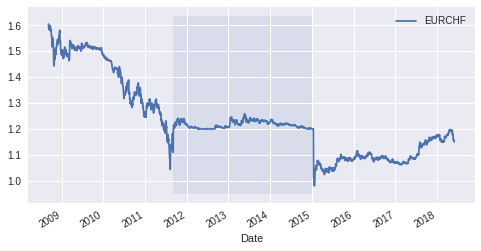

In [0]:


QUAND_TS = "https://www.quandl.com/api/v3/datasets/ECB/EURCHF.json?api_key=o6YKGjyDcseE3LFKrSK3"

# Call Quandl to get all the data
q = requests.get(url = QUAND_TS)
q_json = q.json() 
q_data = q_json['dataset']['data']

# Compute derived series from Quandl Data
dates = []
values = []
q_len = len(q_data)
column_len = len(q_data[0])
column = column_len-1
columns = q_json['dataset']['column_names']
print (columns)
Value = 'EURCHF'
columns = ['Date', Value]

# The following could be easily done using Quandl's
# python API - but I keep it the 'hard way' to allow
# compatibility with Google Colaboratory
df_rates = pd.DataFrame.from_records(q_data, columns = columns)
df_rates['Date'] = pd.to_datetime(df_rates['Date'])
df_rates.set_index('Date', inplace=True)
ax = df_rates[df_rates.index >= pd.Timestamp('2008-09-06')].plot(figsize=(8,4))
ax.fill_betweenx(ax.get_ylim(), pd.Timestamp('2011-09-06'), pd.Timestamp('2015-01-15'), alpha=0.1, zorder = -1)


Sirignano and Cont claim they can make it work by:
* using huge amounts of data:  "*Our data set is a high-frequency record of all orders, transactions and order cancellations for approximately 1000 stocks traded on the NASDAQ between January 1, 2014 and March 31, 2017*" "*In electronic markets such as the NASDAQ, new orders may arrive at high frequency —
sometimes every microsecond — and order books of certain stocks can update millions of
times per day. This leads to TeraBytes of data, which we put to use to build a data-driven
model of the price formation process.*"
* massive computer power:  "* Approximately 500 GPU
nodes are used to train the stock-specific models.*" 
* LSTM Neural Networks: "*The resulting LSTM network involves up to hundreds of thousands of parameters. This is relatively small compared to networks used for instance in image or speech recognition, but
it is huge compared to econometric models traditionally used in finance*"

I have a pet peeve for irreproducible research, and lacking access to terabytes of limit order data hundreds of GPU's I cannot comment on the the paper.

But a very important factor that could explain the success of this approach, is the use of the whole public view of the Limit Order Book (LOB).

Think about it: above I showed how regime changes worked in the case of the EURCHF; after the announcement, the 'floor' of 1.20 CHF to EUR was in effect an unlimited limit order. In fact, the limit order does not have to unlimited to have an effect on following prices; as long as the limit order is 'large':


> *Large limit orders can be "front-run" by "order matching" or "penny jumping". For example, if a buy limit order for 100,000 shares for 1.00 is announced to the market, many traders may seek to buy for 1.01. If the market price increases after their purchases, they will get the full amount of the price increase. However, if the market price decreases, they will likely be able to sell to the limit order trader, for only a one cent loss. [[wiki](https://en.wikipedia.org/wiki/Front_running)]*

Hence, by choosing the whole public Limit Order Book as input to the time series, Sirignano and Cont are using an additional set of features that can provide usefule extra information.

**Note**: Before trying to use neural networks to deal with time series it is worthwile to ask whether we have 'enough' data **and** computer power (which is not the case of most lonely day traders and academics who publish on the web and scientific papers). 


## How could it work ?

Still, I find value in negative results (the [dark matter of research](https://www.aje.com/en/arc/negative-results-dark-matter-research/) ), so for my sake I decided to try a simple Time Series example 'warts and all'.

In a previous example of AI in TimeSeries I showed how an unsupervised learning technique ([clustering](https://medium.com/@gjlr2000/rates-clustering-611a3af9b294)) can be used to identify regime change. But if you click on the example, you will see that having a timeseries with about 2.5k (250 business days for 10 years) datapoints divided in regimes that range from months to years provides very little data for a big neural network like the 'Don Quijote' (which as more than 1 million parameters to train).

There are quite  few sources of material to use LTSM for prediction, but I particularly liked one class in coursera: [Crude Oil price prediction](https://github.com/romeokienzler/developerWorks/blob/master/coursera/ai/week3/lstm_crude_oil_price_prediction.ipynb)

 
Another useful resources are:

* Anomaly Detection for Temporal
Data using Long Short-Term
Memory (LSTM) http://www.diva-portal.org/smash/get/diva2:1149130/FULLTEXT01.pdf
* How to Prepare Sequence Prediction for Truncated Backpropagation Through Time in Keras https://machinelearningmastery.com/truncated-backpropagation-through-time-in-keras/

The following code is a copy of the coursera course, but I will try to give some insights.

[u'Date', u'1 MO', u'3 MO', u'6 MO', u'1 YR', u'2 YR', u'3 YR', u'5 YR', u'7 YR', u'10 YR', u'20 YR', u'30 YR']


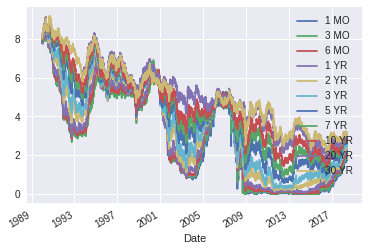

In [0]:


# Treasury rates: we can download them from Quandl
QUAND_TS = "https://www.quandl.com/api/v3/datasets/USTREASURY/YIELD.json?api_key=o6YKGjyDcseE3LFKrSK3"


# Call Quandl to get all the data
q = requests.get(url = QUAND_TS)
q_json = q.json() 
q_data = q_json['dataset']['data']

# Compute derived series from Quandl Data
dates = []
values = []
q_len = len(q_data)
column_len = len(q_data[0])
column = column_len-1
columns = q_json['dataset']['column_names']
print (columns)


# The following could be easily done using Quandl's
# python API - but I keep it the 'hard way' to allow
# compatibility with Google Colaboratory
df_rates = pd.DataFrame.from_records(q_data, columns = columns)
df_rates['Date'] = pd.to_datetime(df_rates['Date'])
df_rates.set_index('Date', inplace=True)
df_rates.plot()

The first thing I do is to use USD rates - just to try something different and check whether the results make sense (I do that because I am more familiar with rates, but also because the data is free and does not require me publishing user id's and passwords)

Visually, I can see that values range between 0 and 10%. 

**Note**: (first wart): pre-defining the range with *all* introduces [look ahead bias](https://www.investopedia.com/terms/l/lookaheadbias.asp), even if for rates it can be claimed the near future will still range between this values. But so far I have seen this error multiple times.



In [0]:
Value = '5 YR'
df_rates = pd.DataFrame.from_records(q_data, columns = columns)
df_data_1 = ((df_rates[['Date',Value]]).sort_index(ascending = False))
print(df_data_1.shape)
df_data_1.head()


(7110, 2)


,Date,5 YR
7109,1990-01-02,7.87
7108,1990-01-03,7.92
7107,1990-01-04,7.91
7106,1990-01-05,7.92
7105,1990-01-08,7.92


Below you can see the data is represented as an array of consecutive days.

**Note**: (2nd wart) this techniques removes useful information that could be relevant - is it a weekend, end of quarter, month  ([weekend effect](https://www.investopedia.com/terms/w/weekendeffect.asp)) ? We could add it back as a 'feature'

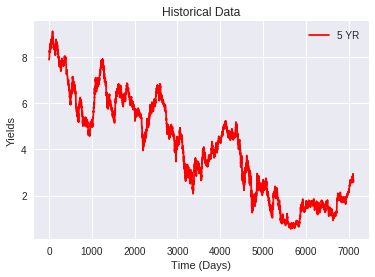

In [0]:
import matplotlib.pyplot as plt
df_data_1_plot = df_data_1.iloc[:,1:2].values
# Visualising the Data
plt.plot(df_data_1_plot, color = 'red', label = Value)
plt.title('Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('Yields')
plt.legend()
plt.show()

In [0]:

#import packages#import 
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import load_model

Using TensorFlow backend.


Here we start entering some 'hyperparameters':


*   batch size and epochs tell the system how fast and how many times to train
*   **training** timesteps tell the system how far back in time to go during training.

**Note**: (3rd wart) The hyperparameters will impact the accuracy of the predictor - and if we only have a small set of data it might be possible that playing with different hyperparameters gives us an 'overfitted neural network' that will work very well **just** in the available set but awufully afterwards.

**Note**: I have seen that the **training**  timesteps are confused with the amount of memory used (as if the system as an ARIMA model) - but it is not the case. LSTM will remember well back in the past. Read 

* How to Prepare Sequence Prediction for Truncated Backpropagation Through Time in Keras https://machinelearningmastery.com/truncated-backpropagation-through-time-in-keras/



In [0]:
# defining the batch size and number of epochs
batch_size = 64
epochs = 120
timesteps = 30

In [0]:
length = len(df_data_1)
print length
length *= 1 - 0.1
print length

7110
6399.0


In [0]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print x
    return (max(train_length_values))

In [0]:
length = get_train_length(df_data_1, batch_size, 0.1)
print length

6336
6336


In [0]:
#Adding timesteps * 2
upper_train = length + timesteps*2
df_data_1_train = df_data_1[0:upper_train]
training_set = df_data_1_train.iloc[:,1:2].values
training_set.shape

(6396, 1)

In [0]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(6396, 1)

**Note**: (1st wart again) - the MinMaxScaler introduces look-ahead bias. The inputs of the neural network need to fall within the range 0 to 1, and just below we used the whole available data set to scale the input.

How about if want to predict stock values (that can rise forever) ? Well, you need to somehow transform your data into something that falls between 0 and 1 - that is why Sirignano and Cont model the probability that the next move is up or down - a number between 0 and 1:


> "*The models therefore predict whether the next price move is up or down*"



In [0]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print length + timesteps
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print len(X_train)
print len (y_train)
print np.array(X_train).shape
print np.array(y_train).shape

6366
6336
6336
(6336, 30)
(6336, 30)


In [0]:
# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print X_train.shape
print y_train.shape

(6336, 30, 1)
(6336, 30, 1)


In [0]:
# Building the LSTM
# Importing the Keras libraries and packages

from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py

Now we setup the architecture of the LSTM neural network: 4 layers, 2 of them LSTM with 10 neurons each and a Dense final one.

**Note** (3rd wart again) - we have more hyperparameters here - layers and neurons - how do we define them ? We can modify them until a network has a better accuracy, but we fall into overfiting - that is why need more and more data - we need different testing sets for each architecture to avoid overfitted models.

**Note** Notice that here (as opposed to the 'Don Quijote' example) the LSTM add a stateful = 'True' command - that means the network will have Long memory.

In [0]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_1 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_2 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_1 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


It is useful to compare the number of parameters to train (1.3k) with the number of data points (6.6k). Compared to the Don Quijote example were we had roughly the same number of parameters and hyperparameters, is a 'good' sign.

**Note** (2nd wart) - the input layer uses 'batches' of 60 points (to make training faster), 30 backward looking training steps and 1 feature. Above we mentioned that we had discarded information -- here we could add it again in the form of another feature, **but** that would increase the number of parameters to train while our data has **not** increased. 

Neural networks seems to have escaped the [curse of dimensionality](https://hackernoon.com/what-killed-the-curse-of-dimensionality-8dbfad265bbe) (the curse says that "the number of training instances needed grows exponentially with the number of dimensions" [link](http://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/)), but still it does not mean you can use a few examples to train a huge neural network.


Below I will start the training of the network -please keep scrolling down to see the results.

In [0]:
for i in range(epochs):
#    print("Epoch: " + str(i))
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size, verbose = 0)
    regressor_mae.reset_states()
    

In [0]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print x
    return (max(test_length_values))

In [0]:
test_length = get_test_length(df_data_1, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print testset_length

6972
7036
7036
640


In [0]:
print upper_train, upper_test, len(df_data_1)

6396 7096 7110


In [0]:
# construct test set

#subsetting
df_data_1_test = df_data_1[upper_train:upper_test] 
test_set = df_data_1_test.iloc[:,1:2].values

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [0]:
#prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print predicted_bcg_values_test_mae.shape

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print predicted_bcg_values_test_mae.shape
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])
#    print predicted_bcg_values_test_mae[j, timesteps-1], test_set[j]

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print y_test.shape

(640, 30, 1)
(640, 30)
(610, 1)


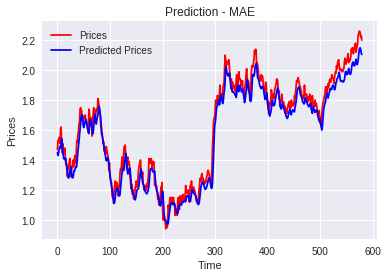

(array([  1.,   3.,  13.,  77., 161., 178., 111.,  28.,   5.,   3.]),
 array([-0.16316795, -0.12250455, -0.08184114, -0.04117773, -0.00051432,
         0.04014909,  0.0808125 ,  0.1214759 ,  0.16213931,  0.20280272,
         0.24346613]),
 <a list of 10 Patch objects>)

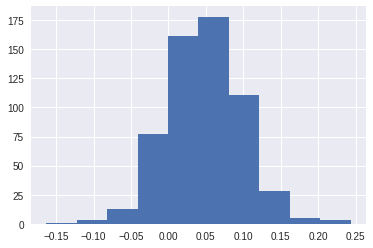

In [0]:
# Visualising the results
plt.plot(test_set[timesteps:len(y_test)], color = 'red', label = 'Prices')
plt.plot(y_test[0:len(y_test) - timesteps], color = 'blue', label = 'Predicted Prices')
plt.title('Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.legend()
plt.show()

err_vector = ((test_set[timesteps:len(y_test)] - y_test[0:len(y_test) - timesteps]))
#plt.plot(err_vector)
plt.hist(err_vector)

## Results - finally

Well, they are pretty poor. 

The graph above does not look too bad because the prediction at least falls 'close by' to the last seen level. However,  the prediction is done only for 1 step - the series is constructed by adding the correct value to the series at each point once it is known for the next day prediction, and even then the prediction has a downward bias which would have cost dearly any trader.

**Note**: the test results have a big bias (5bps undershoot according to the histogram). This is the part where either someone would be tempted fix the bias by making some changes to the hyperparameters (add neurons ? add lags ? etc.) or would train different models in parallel until we find a model which performs better in this final step. That is a **mistake** -- this 'out of sample' is supposed to be the 'proof of the pudding' - you cannot reuse it to have another go at the series. That is why you need lots more data so that you can keep and untouched test set on hand for every model you want to try.

## What did I learn ?

My goal was to show how these LTSM *could* be used. 

Each one of the 'warts' can be addressed and improved when more data (and computer power) is available:

* wart 1: look ahead bias - this requires having a good domain knowledge. 
* wart 2: removing useful information - this requires both the domain knowledge + more data
* wart 3: hyperparameter selection - need even more data to be able to test each different model.

In three words: data, data and data.

**Note** - it is common to think that a 'lot of data' can be overcomed by adding more data points per example -  this timeseries has only one datapoint per day, but maybe we could add lots of other related datapoints the same day ? If we were to do that we would be adding input points to the neural network and would increase the trainable parameter, but we will still have the same number of examples. Put another way - think that you have 10 pictures to train a cat identifier - the system will not improve if you increase the resolution of your pictues to HD instead of low res -- you need *more* pictures.





In [0]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

0.0701804462487


In [0]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mae)

0.05744177693334118


In [0]:
import h5py
regressor_mae.save(filepath="rates5yr_with_mae_30_ts.h5")

In [0]:
# Initialising the LSTM Model with MSE Loss Function

inputs_1_mse = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mse = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mse)
lstm_2_mse = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mse)

output_1_mse = Dense(units = 1)(lstm_2_mse)

regressor_mse = Model(inputs=inputs_1_mse, outputs = output_1_mse)

regressor_mse.compile(optimizer='adam', loss = 'mse')
regressor_mse.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_3 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_4 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_2 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [0]:
epochs = 120
for i in range(epochs):
#    print("Epoch: " + str(i))
    regressor_mse.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size, verbose = 0)
    regressor_mse.reset_states()

In [0]:
predicted_bcg_values_test_mse = regressor_mse.predict(X_test, batch_size=batch_size)
regressor_mse.reset_states()

predicted_bcg_values_test_mse = np.reshape(predicted_bcg_values_test_mse, 
                                       (predicted_bcg_values_test_mse.shape[0], 
                                        predicted_bcg_values_test_mse.shape[1]))
predicted_bcg_values_test_mse = sc.inverse_transform(predicted_bcg_values_test_mse)

pred_mse = []

for j in range(0, testset_length - timesteps):
    pred_mse = np.append(pred_mse, predicted_bcg_values_test_mse[j, timesteps-1])

pred_mse = np.reshape(pred_mse, (pred_mse.shape[0], 1))

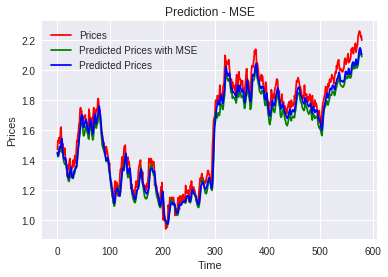

(array([  1.,   2.,   8.,  49., 128., 171., 160.,  51.,   7.,   3.]),
 array([-0.17178941, -0.12745171, -0.08311401, -0.03877631,  0.0055614 ,
         0.0498991 ,  0.0942368 ,  0.1385745 ,  0.1829122 ,  0.2272499 ,
         0.2715876 ]),
 <a list of 10 Patch objects>)

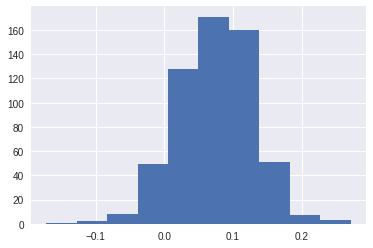

In [0]:
# Visualising the results
plt.plot(test_set[timesteps:len(pred_mse)], color = 'red', label = 'Prices')
plt.plot(pred_mse[0:len(pred_mse) - timesteps], color = 'green', label = 'Predicted Prices with MSE')
plt.plot(y_test[0:len(y_test) - timesteps], color = 'blue', label = 'Predicted Prices')
plt.title('Prediction - MSE')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.legend()
plt.show()

err_vector = ((test_set[timesteps:len(pred_mse)] - pred_mse[0:len(pred_mse) - timesteps]))
#plt.plot(err_vector)
plt.hist(err_vector)

In [0]:
print (predicted_bcg_values_test_mse.shape)
print (X_test.shape)

(640, 30)
(640, 30, 1)


In [0]:
regressor_mse.save(filepath="rates5yr_with_mse_30_ts.h5")